# Problem Statement

Rossmann is a European drug distributor which operates over 3,000 drug stores across seven European countries. Since a lot of drugs come with a short shelf life, that is, they do not have a long expiry date, it becomes imperative for Rossmann to accurately forecast sales at their individual stores. Currently, the forecasting is taken care of by the store managers who are tasked with forecasting daily sales for the next six weeks. 

 

As expected, store sales are influenced by many factors, including promotional campaigns, competition, state holidays, seasonality, and locality.

 

With thousands of individual managers predicting sales based on their unique circumstances and intuitions, the accuracy of the forecasts is quite varied. To overcome this problem, the company has hired you as a data scientist to work on the forecasting problem. As part of your job role, you are tasked with building a forecasting model to forecast the daily sales for the next six weeks. To help you with the same, you have been provided with historical sales data for 1,115 Rossmann stores.



# Importing required libraries

In [6]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import seaborn as sns

# Importing Data

In [39]:
# Data Reading
train = pd.read_csv("Dataset/train.csv")
store = pd.read_csv("Dataset/store.csv")

In [41]:
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


# EDA

In [44]:
# checking train data shape
train.shape

(1017209, 9)

In [46]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [72]:
# finding percentage of null values in each columns
100*train.isnull().sum()/train.shape[0]

Store            0.0
DayOfWeek        0.0
Date             0.0
Sales            0.0
Customers        0.0
Open             0.0
Promo            0.0
StateHoliday     0.0
SchoolHoliday    0.0
dtype: float64

- <b> All data points are valid and thus do not necessitate any imputation or additional analysis.

In [75]:
# describing train datasets
train.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00


In [77]:
# view store dataset
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [79]:
# shape of store datasets
store.shape

(1115, 10)

In [81]:
# print info of store datasets
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [83]:
# finding percentage of null values in each columns
100*store.isnull().sum()/store.shape[0]

Store                         0.000000
StoreType                     0.000000
Assortment                    0.000000
CompetitionDistance           0.269058
CompetitionOpenSinceMonth    31.748879
CompetitionOpenSinceYear     31.748879
Promo2                        0.000000
Promo2SinceWeek              48.789238
Promo2SinceYear              48.789238
PromoInterval                48.789238
dtype: float64

- we need to impute columns having null values
- The lack of promotional values indicates that there are no active promotions in the store, which can be represented by a value of zero.

In [92]:
store['Promo2SinceWeek'].fillna(0, inplace=True)
store['Promo2SinceYear'].fillna(0, inplace=True)
store['PromoInterval'].fillna(0, inplace=True)

- The CompetitionDistance field contains a negligible number of null values; therefore, we will replace these with the mean value.

In [95]:
store['CompetitionDistance'].fillna(store['CompetitionDistance'].mean(), inplace=True)

In [97]:
# checking again null values
100*store.isnull().sum()/store.shape[0]

Store                         0.000000
StoreType                     0.000000
Assortment                    0.000000
CompetitionDistance           0.000000
CompetitionOpenSinceMonth    31.748879
CompetitionOpenSinceYear     31.748879
Promo2                        0.000000
Promo2SinceWeek               0.000000
Promo2SinceYear               0.000000
PromoInterval                 0.000000
dtype: float64

 - The variables CompetitionOpenSinceMonth and CompetitionOpenSinceYear contain null values, which we will address at a later stage following additional analysis.


# Data Analysis

In [151]:
# a generic function to create count plot
def count_plot(features,df):
    cols=4
    rows = len(features)//cols +1
    fig = plt.figure(figsize=(16, rows*5))
    dataframe = df.copy()
    for plot, feature in enumerate(features):
        fig.add_subplot(rows,cols,plot+1)
        fig.tight_layout(h_pad=5, w_pad=5)
        dataframe[feature] = dataframe[feature].fillna('Missing')
        ax = sns.countplot(x=feature, data=dataframe,order = dataframe[feature].value_counts().index)
        plt.xticks(rotation = 90)
        plt.title("for {}".format(feature))
        for p in ax.patches:
            height = p.get_height()
            ax.text(p.get_x()+p.get_width()/2.,
                    height + 3,
                    '{:1.2f}'.format(height/len(dataframe) * 100),
                    ha="center")

# Univariate Data Analysis on datasets

In [154]:
# Store Data categorical fields
store_categorical_fields=['StoreType',
                          'Assortment',
                          'CompetitionOpenSinceMonth',
                          'CompetitionOpenSinceYear',
                          'Promo2',
                          'Promo2SinceWeek',
                          'Promo2SinceYear',
                          'PromoInterval'
                         ]

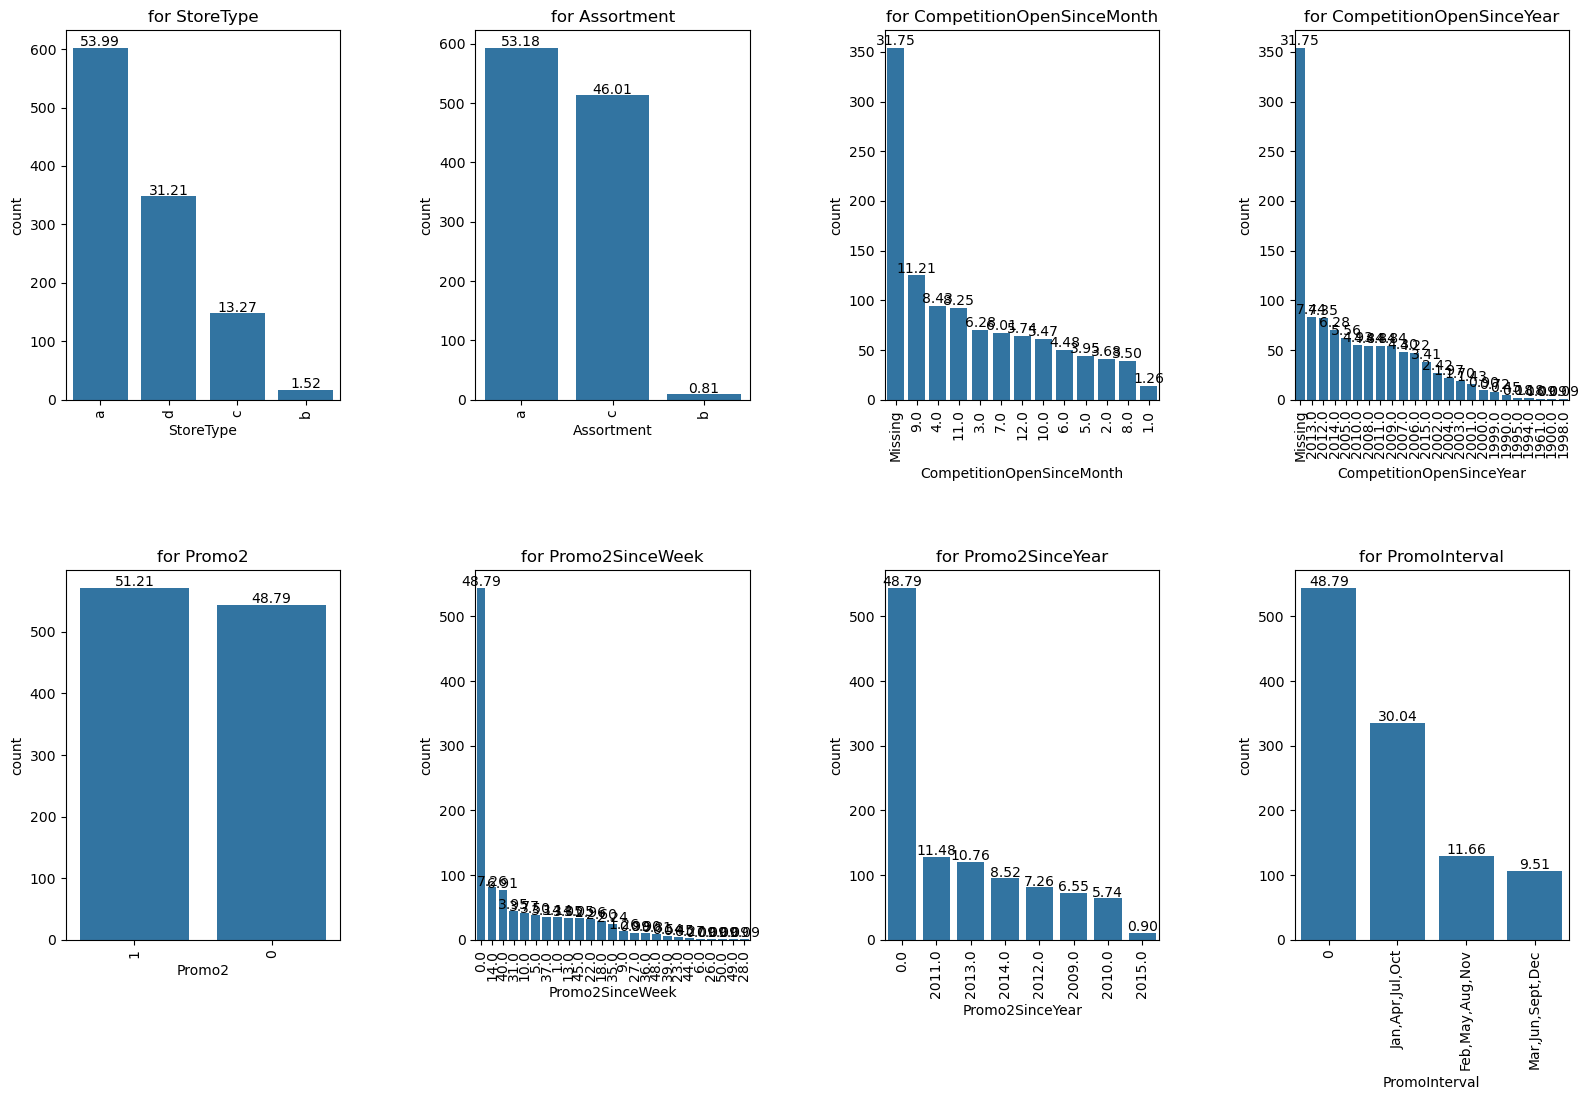

In [156]:
# plot
count_plot(store_categorical_fields,store)

- Observation on store data
    - A significant portion of the stores, nearly 54%, are classified as type A stores.
    - Most of the stores predominantly carry type A assortments,
    - Data for Competition is Null for 31% of the stores, meaning there is either no competition for those stores or the data is missing.
    - 48% of the stores do not have promotions
    - Promotions are primarily focused during the months of January, April, July, and October.

# Analysis for train data

In [166]:
# categoric variables
train_categorical_columns=['DayOfWeek','Open', 'Promo', 'StateHoliday', 'SchoolHoliday']

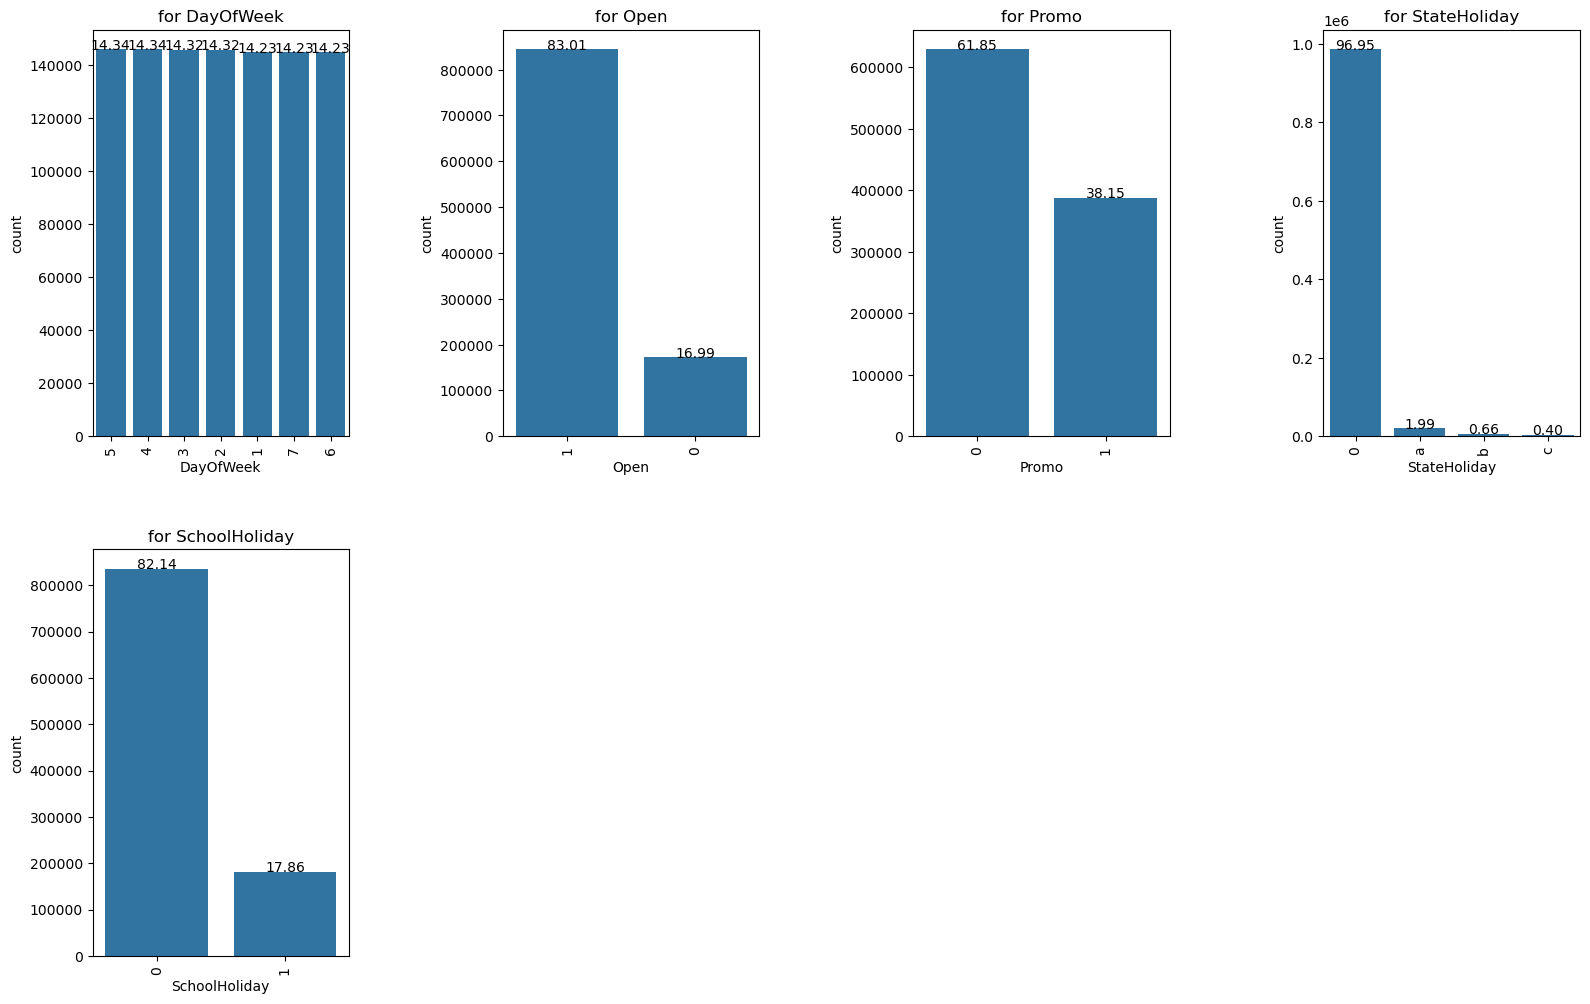

In [168]:
# Count plots for store data
count_plot(train_categorical_columns, train)

- Observation on train data
    - Each day of the week contributes equally.
    - Stores remain closed in only 17% of the data points.
    - Promotions are active in merely 38% of the records.

# Box plot and outlier analysis on datasets

## For store data

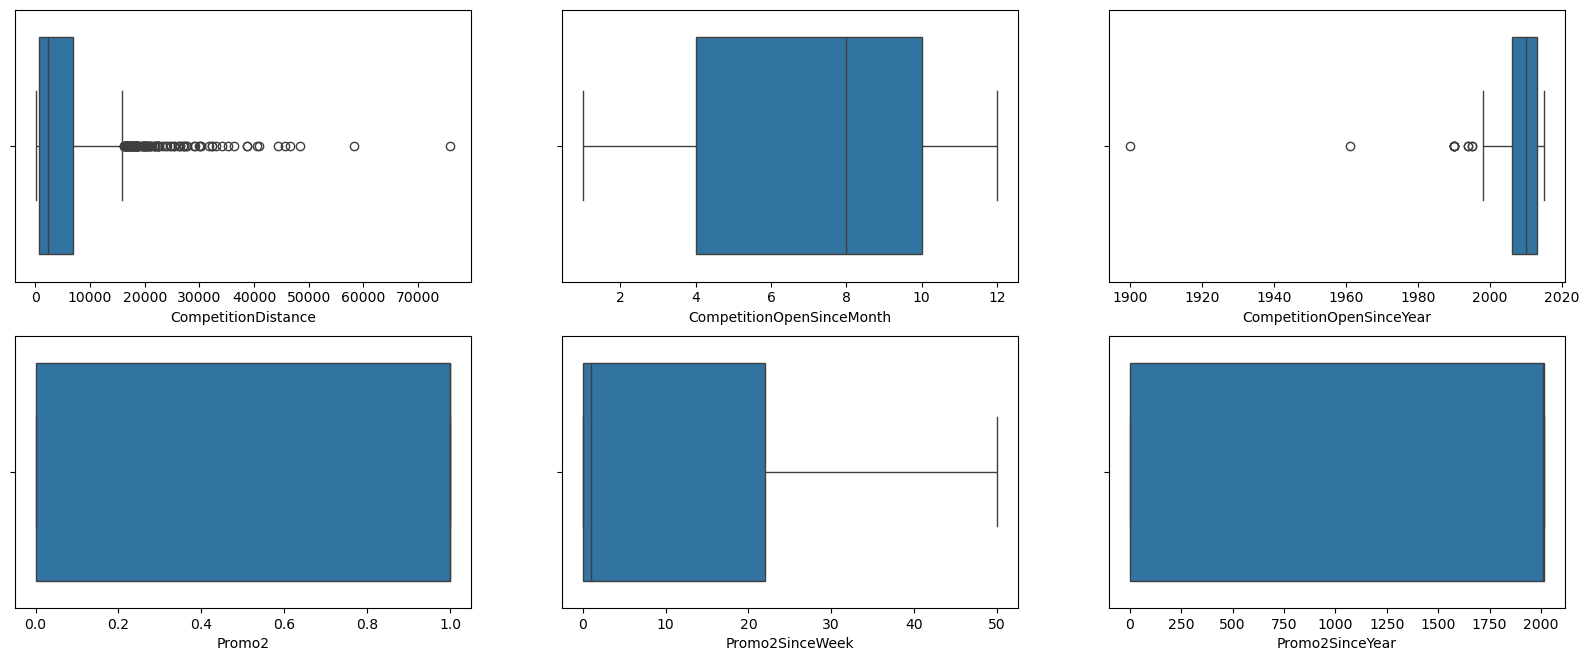

In [177]:
plt.figure(figsize=(20, 12))
plt.subplot(3,3,1)
sns.boxplot(x = 'CompetitionDistance', data = store)
plt.subplot(3,3,2)
sns.boxplot(x = 'CompetitionOpenSinceMonth', data = store)
plt.subplot(3,3,3)
sns.boxplot(x = 'CompetitionOpenSinceYear',data = store)
plt.subplot(3,3,4)
sns.boxplot(x = 'Promo2', data = store)
plt.subplot(3,3,5)
sns.boxplot(x = 'Promo2SinceWeek', data = store)
plt.subplot(3,3,6)
sns.boxplot(x = 'Promo2SinceYear', data = store)
plt.show()

- From above box plot
    - It indicate the presence of outliers in the attributes of CompetitionDistance and CompetitionOpenSinceYear. A thorough analysis of these outliers is necessary.
    - Regarding CompetitionDistance, it is advisable to exclude values that exceed the 99th percentile. We will adjust any values that surpass the 99th percentile to align with the 99th percentile threshold.

In [182]:
# Capping values of CompetitionDistance to 99th percentile
store.loc[store.CompetitionDistance>store.CompetitionDistance.quantile(.99),'CompetitionDistance']=store.CompetitionDistance.quantile(.99)

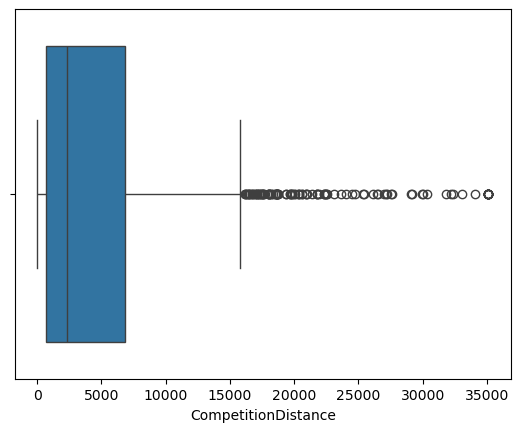

In [184]:
sns.boxplot(x = 'CompetitionDistance', data = store)
plt.show()

- The distance values seem to be in considerable range now.
- Checking for CompetitionOpenSinceYear

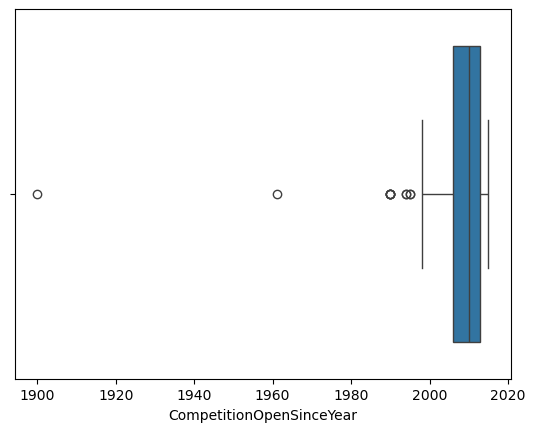

In [187]:
sns.boxplot(x = 'CompetitionOpenSinceYear', data = store)
plt.show()

In [189]:
store['CompetitionOpenSinceYear'].isnull().sum()

354

- CompetitionOpenSinceYear is null for 354 stores

In [192]:
# Checking the values of stores CompetitionDistance is null 
store.loc[store.CompetitionDistance.isnull(),['CompetitionDistance','CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Store']]

,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Store


- can be imputed them with zero

In [195]:
store.loc[store.CompetitionDistance.isnull(),'CompetitionOpenSinceMonth']=0
store.loc[store.CompetitionDistance.isnull(),'CompetitionOpenSinceYear']=0
store.loc[store.CompetitionDistance.isnull(),'CompetitionDistance']=0

In [197]:
100*store.isnull().sum()/store.shape[0]

Store                         0.000000
StoreType                     0.000000
Assortment                    0.000000
CompetitionDistance           0.000000
CompetitionOpenSinceMonth    31.748879
CompetitionOpenSinceYear     31.748879
Promo2                        0.000000
Promo2SinceWeek               0.000000
Promo2SinceYear               0.000000
PromoInterval                 0.000000
dtype: float64

- CompetitionOpenSinceMonth and CompetitionOpenSinceYear are null for 31% of stores, lets check those columns

In [201]:
store.loc[store.CompetitionOpenSinceMonth.isnull(),['CompetitionDistance','CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Store']]

,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Store
11,1070.0,NaN,NaN,12
12,310.0,NaN,NaN,13
15,3270.0,NaN,NaN,16
18,3240.0,NaN,NaN,19
21,1040.0,NaN,NaN,22
...,...,...,...,...
1095,1130.0,NaN,NaN,1096
1099,540.0,NaN,NaN,1100
1112,9260.0,NaN,NaN,1113
1113,870.0,NaN,NaN,1114


In [203]:
store.loc[store.CompetitionOpenSinceYear.isnull(),['CompetitionDistance','CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Store']]

,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Store
11,1070.0,NaN,NaN,12
12,310.0,NaN,NaN,13
15,3270.0,NaN,NaN,16
18,3240.0,NaN,NaN,19
21,1040.0,NaN,NaN,22
...,...,...,...,...
1095,1130.0,NaN,NaN,1096
1099,540.0,NaN,NaN,1100
1112,9260.0,NaN,NaN,1113
1113,870.0,NaN,NaN,1114


- No data is available for competition store openings, let's impute them with zero

In [206]:
store.CompetitionOpenSinceYear.fillna(0,inplace=True)
store.CompetitionOpenSinceMonth.fillna(0,inplace=True)

In [208]:
100*store.isnull().sum()/store.shape[0]

Store                        0.0
StoreType                    0.0
Assortment                   0.0
CompetitionDistance          0.0
CompetitionOpenSinceMonth    0.0
CompetitionOpenSinceYear     0.0
Promo2                       0.0
Promo2SinceWeek              0.0
Promo2SinceYear              0.0
PromoInterval                0.0
dtype: float64

# Merging the datasets

In [211]:
train = train.merge(right=store, on='Store', how='inner')

In [213]:
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,0.0,0.0,0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,0.0,0.0,0


In [215]:
# checking shape
train.shape

(1017209, 18)

In [217]:
# Checking percentage of null records
100*train.isnull().sum()/train.shape[0]

Store                        0.0
DayOfWeek                    0.0
Date                         0.0
Sales                        0.0
Customers                    0.0
Open                         0.0
Promo                        0.0
StateHoliday                 0.0
SchoolHoliday                0.0
StoreType                    0.0
Assortment                   0.0
CompetitionDistance          0.0
CompetitionOpenSinceMonth    0.0
CompetitionOpenSinceYear     0.0
Promo2                       0.0
Promo2SinceWeek              0.0
Promo2SinceYear              0.0
PromoInterval                0.0
dtype: float64

# Bivariate Analysis on Data

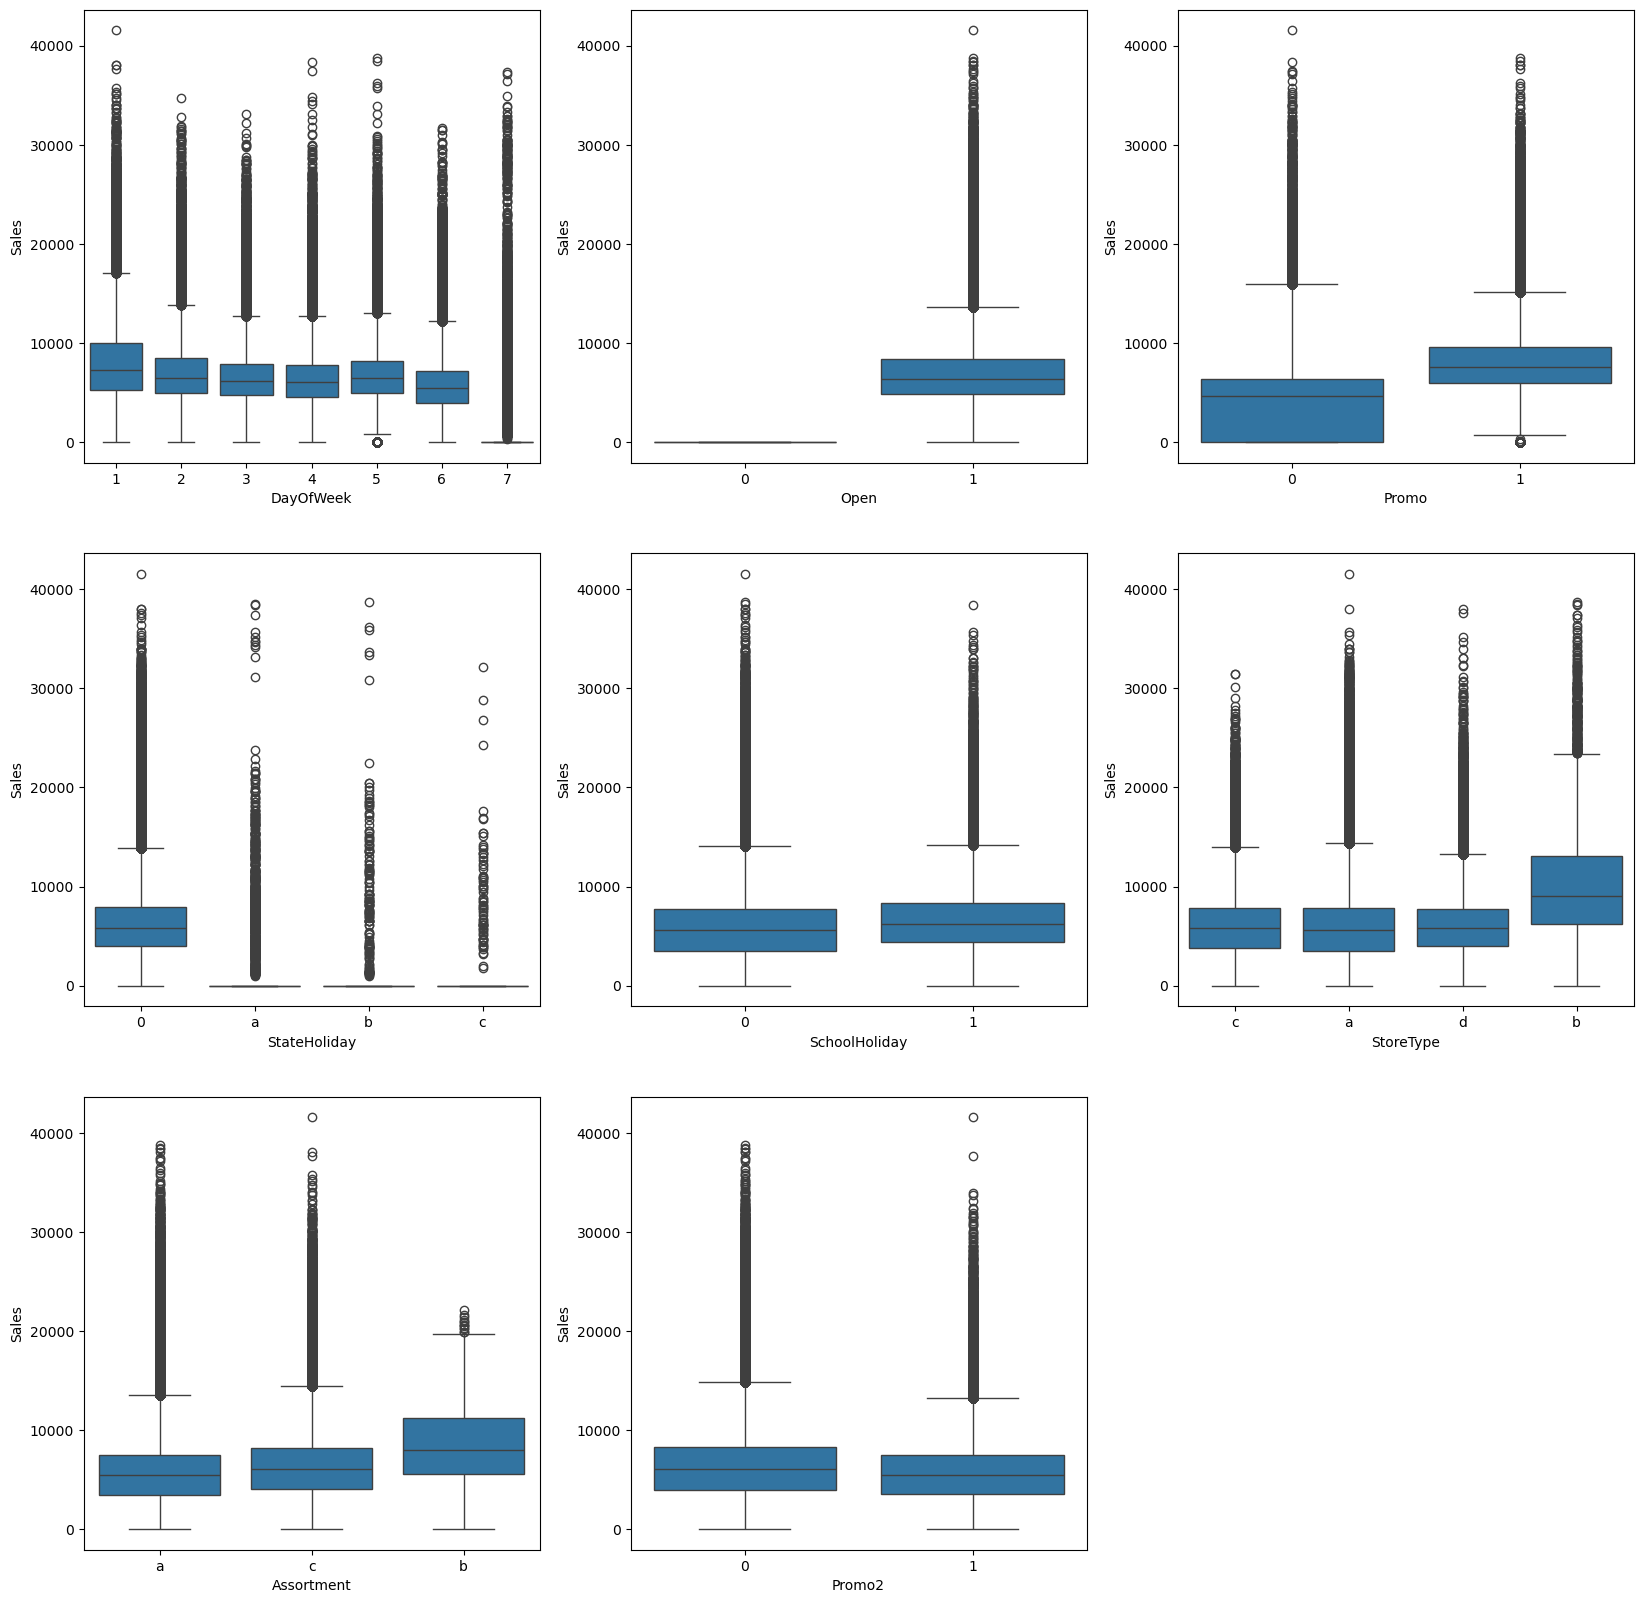

In [224]:
# Boxplots of attributes against Sales

plt.figure(figsize=(20, 20))
plt.subplot(3,3,1)
sns.boxplot(x = 'DayOfWeek', y = 'Sales', data = train)
plt.subplot(3,3,2)
sns.boxplot(x = 'Open', y = 'Sales', data = train)
plt.subplot(3,3,3)
sns.boxplot(x = 'Promo', y = 'Sales', data = train)
plt.subplot(3,3,4)
sns.boxplot(x = 'StateHoliday', y = 'Sales', data = train)
plt.subplot(3,3,5)
sns.boxplot(x = 'SchoolHoliday', y = 'Sales', data = train)
plt.subplot(3,3,6)
sns.boxplot(x = 'StoreType', y = 'Sales', data = train)
plt.subplot(3,3,7)
sns.boxplot(x = 'Assortment', y = 'Sales', data = train)
plt.subplot(3,3,8)
sns.boxplot(x = 'Promo2', y = 'Sales', data = train)
plt.show()


- Observation on merged Data
    - Sales are higher on 1st, 2nd and 5th weekdays. Sales are very low on 7th weekday.
    - Sales are higher when promotion is 1
    - On state holidays, a, b and c, sales are low
    - School holidays do not seem to impact sales
    - Store type B has higher % of sales than other store types
    - Assortment type B has higher sales
    - Promo2 does not seem to have much contribution to sales

## Scatter Plot Analysis

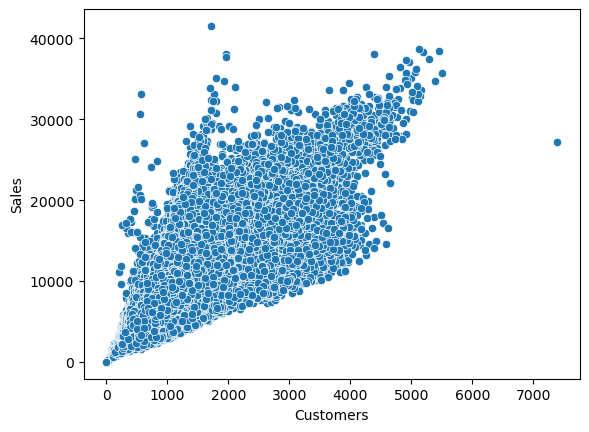

In [230]:
sns.scatterplot(x = 'Customers', y = 'Sales', data = train)
plt.show()

- Observation increase number of customers correlates an increase in sales

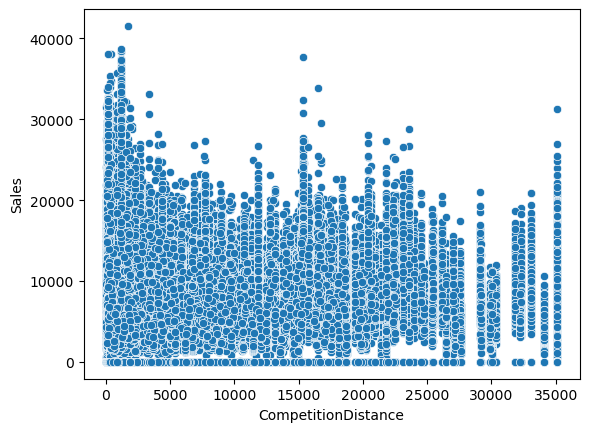

In [234]:
# Boxplots of Customers against Sales
sns.scatterplot(x = 'CompetitionDistance', y = 'Sales', data = train)
plt.show()

- from above plot competition does not seem to have any correlations against sales

## Multivariate Analysis

## categorical variables

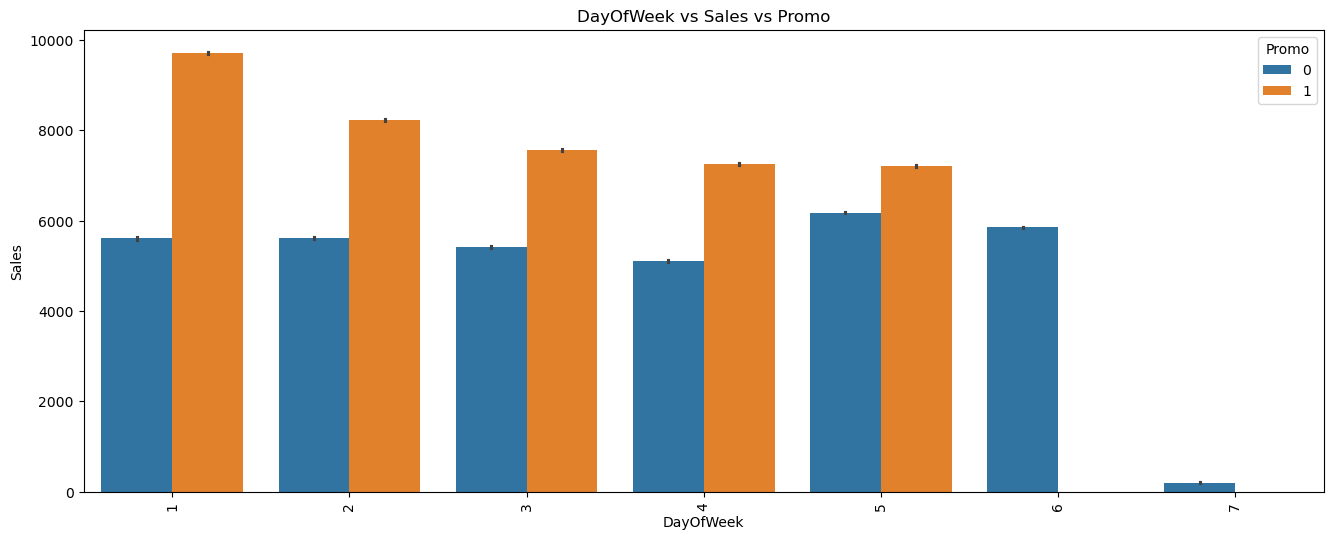

In [242]:
plt.figure(figsize=(16, 6))
sns.barplot(x='DayOfWeek',y='Sales',hue='Promo',data=train)
plt.title("DayOfWeek vs Sales vs Promo")
plt.xticks(rotation = 90)
plt.show()

- From above plot it seems, promotion has a strong co-relation with sales of the stores.

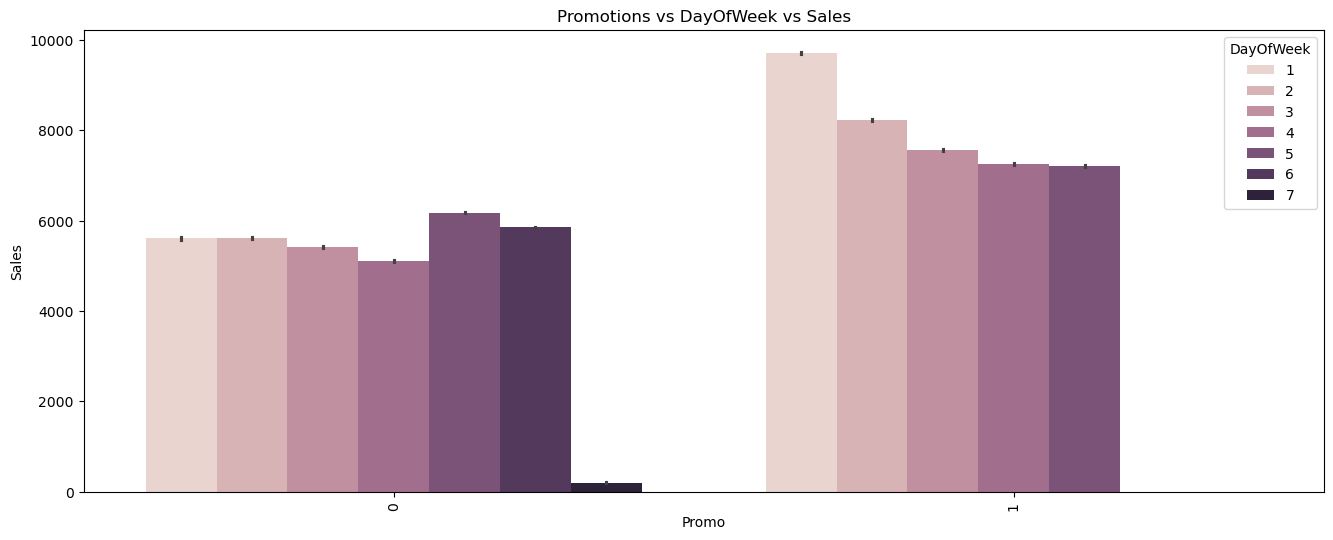

In [245]:
plt.figure(figsize=(16, 6))
sns.barplot(x='Promo',y='Sales',hue='DayOfWeek',data=train)
plt.title("Promotions vs DayOfWeek vs Sales")
plt.xticks(rotation = 90)
plt.show()

- From above plot, it seems days at the start of the week are higher Sales than sales of other days

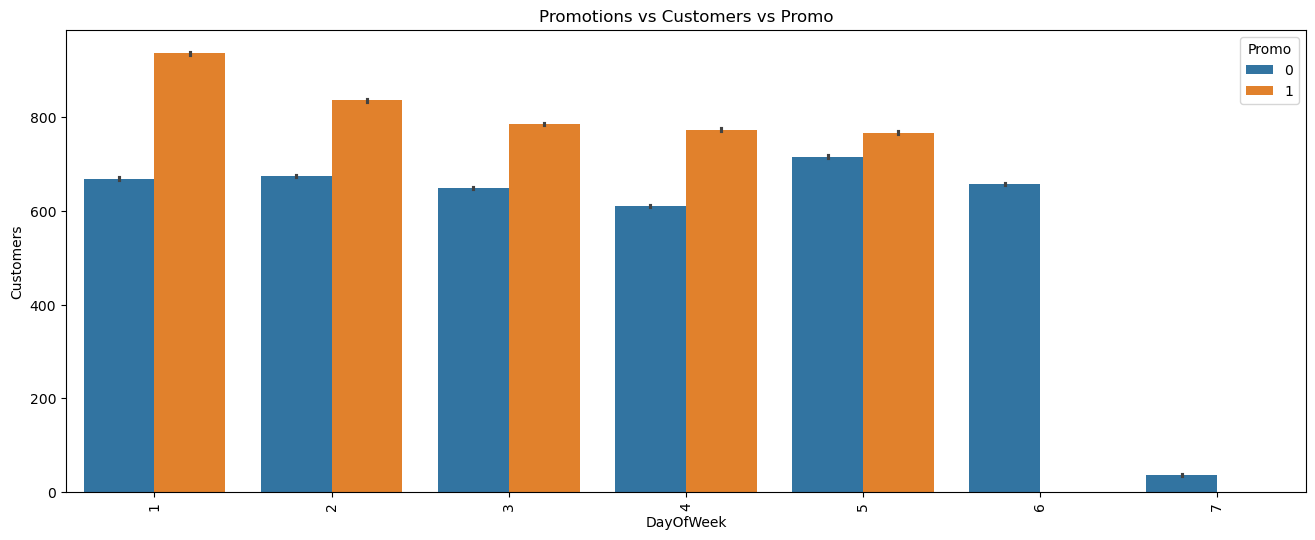

In [264]:
# Checking co-relation between Days vs Customers vs Promo 
plt.figure(figsize=(16, 6))
sns.barplot(x='DayOfWeek',y='Customers',hue='Promo',data=train)
plt.title("Promotions vs Customers vs Promo")
plt.xticks(rotation = 90)
plt.show()

- From above plot, it observerd, customers are higher on weekdays and when promotios are active

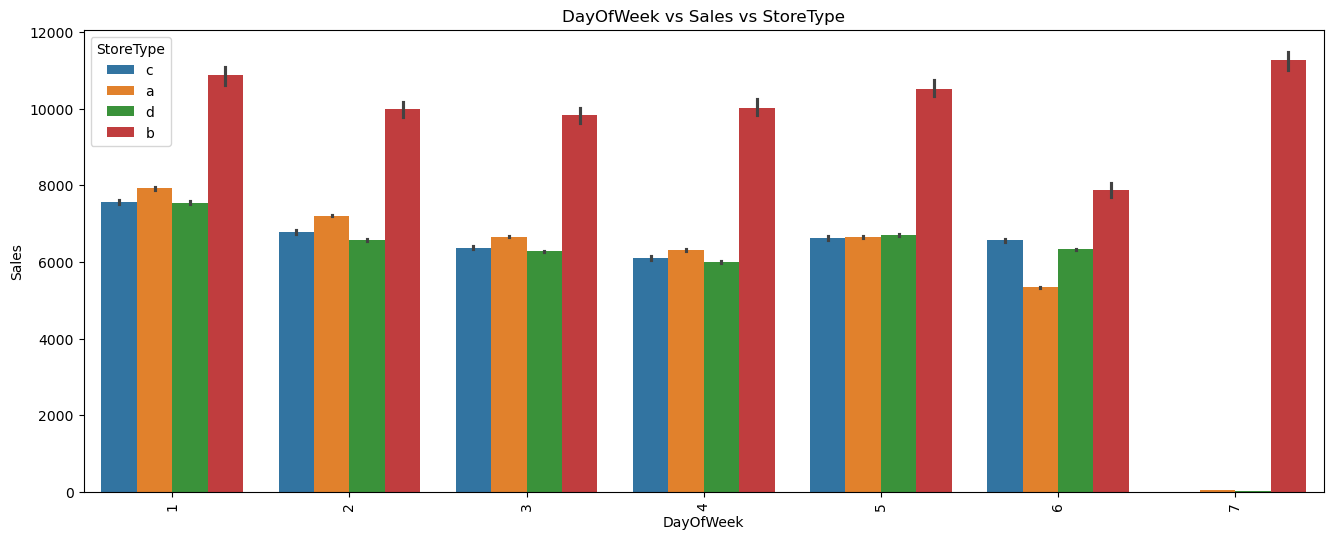

In [267]:
# Checking co-relation between Days vs Sales vs StoreType 

plt.figure(figsize=(16, 6))
sns.barplot(x='DayOfWeek',y='Sales',hue='StoreType',data=train)
plt.title("DayOfWeek vs Sales vs StoreType")
plt.xticks(rotation = 90)
plt.show()

- Sales for store type b is the highest among all days including day 7 where sales for other store type is almost zero. On day 6, the difference in sales among store type is marginally lower than other days

## numerical variables

<Figure size 4000x4000 with 0 Axes>

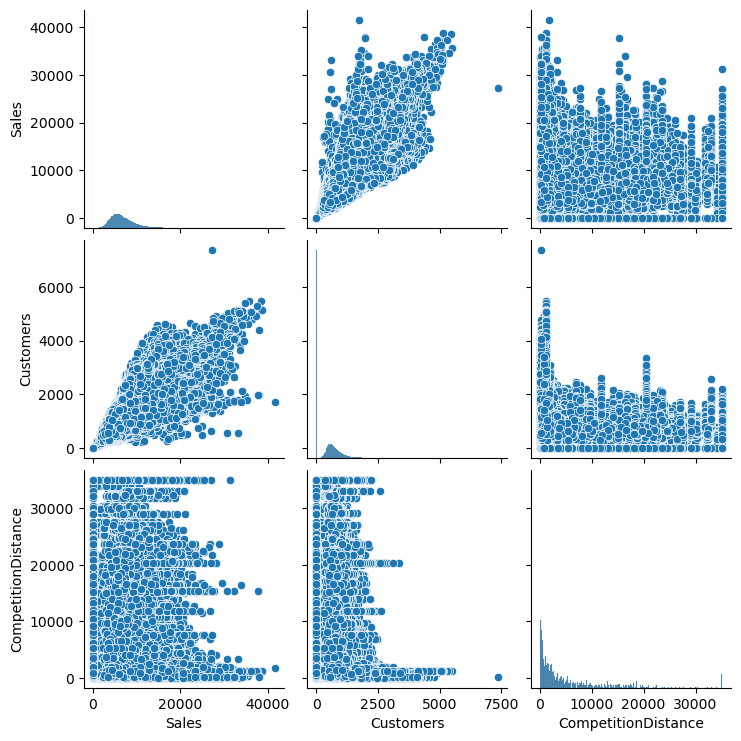

In [274]:
# Pairwise plot

plt.figure(figsize=(40, 40))
sns.pairplot(train[['Sales','Customers','CompetitionDistance']])
plt.show()

- From above plot, we can see that as customers increase, sales also increases.

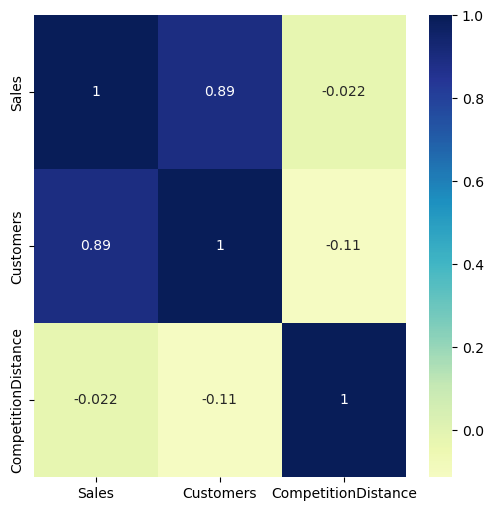

In [277]:
# Checking co-relation coefficients for numercial variables

# plot heat map for corr
cor = train[['Sales','Customers','CompetitionDistance']].corr()
plt.figure(figsize = (6, 6))
sns.heatmap(cor, annot = True,center=0.4,cmap="YlGnBu")
plt.show()

- Sales and customer have a very strong co-relation with a factor of 0.89. For other variables, it is insignificant.

# Feature Engineering